# Playing Azul with Deep Reinforcement Learning

Deep reinforcement learning is a technique that combines deep neural network and reinforcement learning, and it could largely improve the accuracy and precision of the result of some policy-making problems. [A general reinforcement learning algorithm that masters chess, shogi and Go through self-play](https://kstatic.googleusercontent.com/files/2f51b2a749a284c2e2dfa13911da965f4855092a179469aedd15fbe4efe8f8cbf9c515ef83ac03a6515fa990e6f85fd827dcd477845e806f23a17845072dc7bd?fbclid=IwAR1CiRCE0a5nrZBQs2A2Ezw3fh3VUg7JWFC0m8ZKNDIp4xOzqPuhUmTgYQk) showed a groundbreaking achievement of reinforcement learning. Following questions will also be based on the methods of this paper but in new games.

## 1. basic structure of deep reinforcement learning (Tic-Tac-Toe as example)

For the approach described in the paper, the deep neural network learns a map:

$$f(s; \theta) = (p, v).$$
        
The map (with parameters $\theta$) takes in a state $s$ and outputs a vector of move probabilities $p$ and an estimate of the outcome $v$. The vector of probabilities $p$ is called a *policy*.



In [ ]:
!pip install jax
!pip install flax
!pip install optax
!pip install networkx

In [2]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax import traverse_util
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import matplotlib.pyplot as plt
import networkx as nx

### 1) states function

You need to implement `get_next_state` and `get_reward` function.

**Hint:** In this game, we will use 1 to represent player 1 and -1 for player 2.

In [3]:

def init_board():
  return np.zeros((3, 3), dtype=int).flatten()

def flip_board(board):
  return -board

def get_valid_mask(board):
  return board == 0

# #Always assume action is made by player 1
# def get_next_state(board, action):
#   return board.flatten().at[action].add(1).reshape(board.shape)

#Always assume action is made by player 1
def get_next_state(board, action):
  if(board[action] == 1 or board[action] == -1):
    print("Illegal Move")
    print(board.reshape((3,3)))
    print(action)
    print(get_reward(board))
    assert False
  next_board = board.copy()
  next_board[action] = 1
  return next_board

def sample_action(action_dist):
  action_dist = action_dist.flatten() / action_dist.sum()
  return np.random.choice(action_dist.shape[0], p=action_dist)

def disp_board(board):
  plt.imshow(board)

diag_mask = np.eye(3)
ld_mask = np.eye(3)[::-1, :]
def get_reward(board): #Assume move and flip, so board can only be lost
    b = board.reshape((3,3))
    diag = np.sum(diag_mask*b) <= -3
    diag_l = np.sum(ld_mask*b) <= -3
    row = np.min(b@np.ones(3)) <= -3
    col = np.min(b.T@np.ones(3)) <= -3
    reward = -int(diag or diag_l or row or col)
    return reward, (reward != 0 or (board == 0).sum() == 0)

Now we can test the basic structure of policy and action. You need to implement the key code.

In [5]:
for i in range(200):
  board = init_board()
  for i in range(10):
    # _, rng = jax.random.split(rng, 2)
    action_dist = np.ones(board.shape) * get_valid_mask(board)
    next_action = sample_action(action_dist)
    # print(board.reshape((3,3)), next_action)
    board = flip_board(get_next_state(board, next_action))
    reward, game_over = get_reward(board)
    if(game_over):
      break
print(board.reshape((3, 3)), reward, game_over)

[[-1 -1 -1]
 [ 1 -1  1]
 [ 1  1  0]] -1 True


This essay uses Monte Carlo Tree Search(MCTS) algorithm, which need to be implemented in the below.

Each round of Monte Carlo tree search consists of four steps:

**Selection**: Start from root $R$ and select successive child nodes until a leaf node $L$ is reached. The root is the current game state and a leaf is any node that has a potential child from which no simulation (playout) has yet been initiated.

**Expansion**: Unless $L$ ends the game decisively (e.g. win/loss/draw) for either player, create one (or more) child nodes and choose node $C$ from one of them. Child nodes are any valid moves from the game position defined by $L$.

**Simulation**: Complete one random playout from node $C$. This step is sometimes also called playout or rollout. A playout may be as simple as choosing uniform random moves until the game is decided (for example in chess, the game is won, lost, or drawn).

**Backpropagation**: Use the result of the playout to update information in the nodes on the path from $C$ to $R$.

Each state-action pair $(s, a)$ stores a set of statistics, $\{N(s, a), W(s, a), Q(s, a), P(s, a)\}$, where $N(s, a)$ is the visit count, $W(s, a)$ is the total action-value, $Q(s, a)$ is the mean action-value, and $P(s, a)$ is the prior probability of selecting $a$ in $s$. Each simulation begins at the root node of the search tree, $s_0$, and finishes when the simulation reaches a leaf node $s_L$ at time-step $L$. At each of these timesteps, $t < L$, an action is selected, $a_t = argmax_a(Q(s_t, a) + U(s_t, a))$, using a variant of the PUCT algorithm, $U(s, a) = C(s)P(s, a)\sqrt{N(s)}/(1 + N(s, a))$, where $N(s)$ is
the parent visit count and $C(s)$ is the exploration rate, which grows slowly with search time, $C(s) = log ((1 + N(s) + c_{base})/c_{base}) + c_{init}$, but is essentially constant during the fast training games.

The stochastic policy obtained after performing the MCTS uses exponentiated counts, i.e. 
$$π(s)=N(s,⋅)^{1/τ}/∑_b(N(s,b)^{1/τ})$$, where $τ$ is the temperature and controls the degree of exploration. AlphaGo Zero uses $τ = 1$ (simply the normalised counts) for the first 30 moves of each game, and then sets it to an infinitesimal value (picking the move with the maximum counts).

In [26]:
def toy_model(state):
    return np.ones(state.shape) / state.shape[0], 0.1

STATE_DIM = 9 #Dimension of 4x4 tic-tac-toe board
ACTION_DIM = 9
MAX_SIZE = int(1e3)
C_BASE, C_INIT = 1.0, 1.0
class MCTS:
    def __init__(self, max_size=MAX_SIZE):
        self.state = np.zeros((max_size, STATE_DIM))
        self.state_lookup = {} #Maps state representation to index
        self.expanded = []

        self.visit_count = np.zeros(max_size)
        self.action_visits  = np.zeros((max_size, ACTION_DIM), dtype=int)
        self.action_total_value = np.zeros((max_size, ACTION_DIM))
        self.action_mean_value = np.zeros((max_size, ACTION_DIM))
        self.action_prior = np.zeros((max_size, ACTION_DIM))
        # self.action_children = np.zeros((MAX_SIZE, ACTION_DIM), dtype=int) - 1
    
    #Assumes state is already expanded, and uses MCTS info to pick best action using weighted combination of 
    #model prior and MCTS value estimates
    def select_action(self, state, state_index):
        state_visits = self.visit_count[state_index]
        # exp_rate = np.log((1+state_visits + C_BASE)/C_BASE) + C_INIT
        exp_rate = 2
        model_prior = self.action_prior[state_index]
        sa_visits = self.action_visits[state_index]
        sa_mean_value = (1+self.action_mean_value[state_index])/2 #Normalize to [0, 1]
        # print(state_index, sa_mean_value)
        action_distr = (sa_mean_value + exp_rate*np.sqrt(state_visits)*model_prior/(1+sa_visits))*get_valid_mask(state)
        # print("action distr", action_distr)
        action = np.argmax(action_distr)
        # print(state[action])
        if(state[action] != 0):
            print("State", state.reshape((3,3)))
            print("action", action)
            print("exp rate", exp_rate)
            print("sa mean value", sa_mean_value, sa_visits)
            print("action distr", action_distr)
            print("model prior", model_prior)
            print("action_mask", get_valid_mask(state))
        return action

    def get_action_prob(self, state_index, temperature=1):
        """
        Select action according to the visit count distribution and the temperature.
        """
        action_visits = self.action_visits[state_index]
        if temperature == 0:
            a = np.argmax(action_visits)
            r = np.zeros(action_visits.shape)
            r[a] = 1.0
            return r
        elif temperature == float("inf"):
            return np.ones(action_visits.shape)/action_visits.shape[0]
        else:
            # See paper appendix Data Generation
            visit_count_distribution = np.power(action_visits, 1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            return visit_count_distribution
    
    #Add a new node to the mcts tree for the state, and model prior for actions on that state
    def expand_node(self, state, action_probs):
        state_index = len(self.expanded)
        # print("state index", state_index)
        self.expanded.append(True)
        self.state_lookup[state.tobytes()] = state_index

        self.state[state_index] = state
        self.visit_count[state_index] += 1

        valid_moves = get_valid_mask(state)
        action_probs = (action_probs + 1e-6) * valid_moves  # mask invalid moves
        action_probs /= np.sum(action_probs)
        self.action_prior[state_index] = action_probs
        return state_index

    def search_iter(self, state_index, model):
        search_path = []
        path_actions = []

        curr_index = state_index
        curr_state = self.state[state_index]

        # Loop until reaching an untracked state
        while curr_index >= 0:
            search_path.append(curr_index)
            action = self.select_action(curr_state, curr_index)
            path_actions.append(action)
            curr_state = flip_board(get_next_state(curr_state, action)) #Flip board so moves are always made from P1 perspective
            nsr = curr_state.tobytes()
            if(nsr in self.state_lookup):
                curr_index = self.state_lookup[nsr]
            else:
                curr_index = -1

        # The value of the new state from the perspective of the other player
        next_state = curr_state
        value, game_over = get_reward(next_state)
        value = -value
        if not game_over:
            # If the game has not ended:
            # EXPAND
            action_probs, value = model(next_state)
            valid_moves = get_valid_mask(next_state)
            action_probs = action_probs * valid_moves  # mask invalid moves
            action_probs /= np.sum(action_probs)
            self.expand_node(next_state, action_probs)
        
        #Backpropagate MCTS search path
        for i in range(len(search_path)-1, -1, -1):
            si, a = search_path[i], path_actions[i]
            self.visit_count[si] += 1
            self.action_visits[si, a] += 1
            self.action_total_value[si, a] += value
            self.action_mean_value[si, a] = self.action_total_value[si, a] / self.action_visits[si, a]
            value *= -1

        # print("search path", search_path)
        # print("search visits after update", [self.visit_count[s] for s in search_path])
        
    def mcts_eval(self, state, model, num_sims):
        # print("Expanded len", len(self.expanded))
        root_state = state
        action_prior, value_est = model(root_state)
        root_index = self.expand_node(root_state, action_prior)
        # print("Root index", root_index)
        for _ in range(num_sims):
            self.search_iter(root_index, model)
        return root_index
    
    def visualize_tree(self):
        G = nx.Graph()
        node_labels = {}
        edge_labels = {}
        for state_index in self.state_lookup.values():
            visited_actions = self.action_visits[state_index].nonzero()[0]
            action_values = self.action_mean_value[state_index, visited_actions]
            state = self.state[state_index]
            for action, value in zip(visited_actions, action_values):
                child_state = flip_board(get_next_state(state, action))
                # print(child_state.reshape((3,3)))
                if(child_state.tobytes() in self.state_lookup):
                    child_index = self.state_lookup[child_state.tobytes()]
                    G.add_edge(state_index, child_index)
                    edge_labels[(state_index, child_index)] = f'{value:.2f}'
            node_labels[state_index] = f"{state_index}, {self.action_visits[state_index].sum()}" 

        plt.figure()
        pos = nx.spring_layout(G, scale=2.5)
        nx.draw(
            G, pos, edge_color='black', width=1, linewidths=1, node_size=1000, 
            node_color='pink', alpha=0.9,
            labels=node_labels
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        plt.axis('off')
        plt.title("MCTS Graph Visualization")
        plt.show()

Now we can try a few simple situations to test whether our model can correctly evaluate positions. 

In [27]:
#In the simplest case, the game can be won in one move
winning_state = np.array([1, 0,  0, 0, 1,  0, 0,  0, 0])
print("Board Initial State\n", winning_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(winning_state, toy_model, 500)

print("MCTS Expected Action Value")
print(mcts.action_mean_value[0].reshape((3,3)))

print("MCTS Visit Counts") #Board shows how many times the MCTS revisited each potential move. 
print(mcts.action_visits[0].reshape((3,3)))

Board Initial State
 [[1 0 0]
 [0 1 0]
 [0 0 0]]
MCTS Expected Action Value
[[ 0.          0.6         0.61666667]
 [-0.04545455  0.         -0.01666667]
 [ 0.07692308  0.6         1.        ]]
MCTS Visit Counts
[[  0  31  30]
 [ 11   0  12]
 [ 13  30 373]]


### Q1
Mathematically, why is the visit count highest for the winning move? Why does the algorithm try other moves as well? 
### Q2
The move selection algorithm is deterministic, so why is the visit count different for the upper-right, and lower-left corners? 

### A1/2
The PUCT algorithm tries to both explore, and select valuable moves, while determining the next node to expand in the MCTS algorithm. The formula for action weight puts a strong value on the average return from a move, so that the model will periodically return to high performing moves. At the same time, it downweights potential moves by the number of times it's made them, which is why it occasionally tries other moves, even after finding that the lower-right corner gives an instant win. 

Board Initial State
 [[ 1  1 -1]
 [-1  0  0]
 [-1  0  0]]
MCTS Expected Action Value
[[ 0.          0.          0.        ]
 [ 0.          0.89035088 -0.63571429]
 [ 0.         -0.54       -0.54      ]]


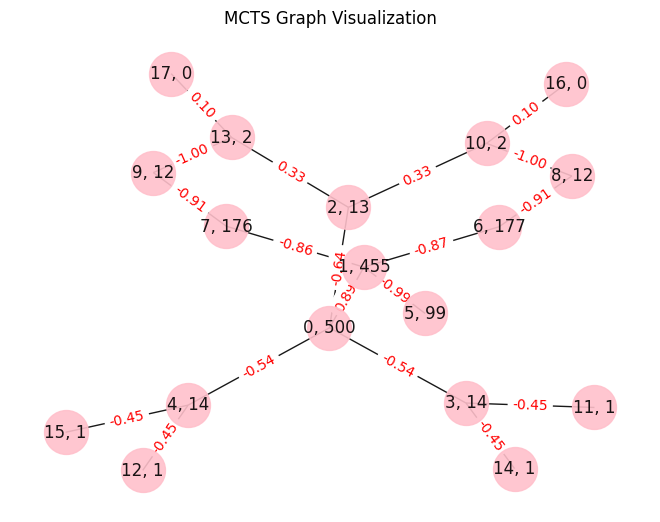

In [30]:
root_state = np.array([1, 1,  -1, -1, 0,  0, -1,  0, 0])
print("Board Initial State\n", root_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(root_state, toy_model, 500)

print("MCTS Expected Action Value")
print(mcts.action_mean_value[0].reshape((3,3)))

mcts.visualize_tree()

#### The code above shows the MCTS rollout for another state, in which the game can be won with a move at the center, and is lost otherwise with perfect play. The MCTS rollout correctly converges to a high value for the center move, and negative values for everything else. 

### Q1
In the limit of MCTS depth, should the tree converge to a value of 1.0 for the center move? 

### A1
No, the MCTS also values exploration, so even with infinite depth, it will still make some fraction of incorrect moves after the winning center move. 

### Q2
The tree above shows how often each state is visited, and shows the estimated value of actions stemming from each state along edges. Why do so many edges in the tree have a value of 0.1? **Hint:** Look at the outputs of the toy model. 

### A2
Value estimates of 0.1 come from states that aren't expanded further until they reach a win, loss, or draw. The only value propagated up the tree is the model's estimate for the state's value, which is always 0.1 for the toy model. 

# Full MCTS Visualization
Tic-tac-toe is a small enough game that it's possible to plot the entire MCTS for some subsets. In the following code, we plot the states visited in MCTS, along with the number of times the tree search took actions to visit that state, and the estimated value of the action leading to this state from tree search. 

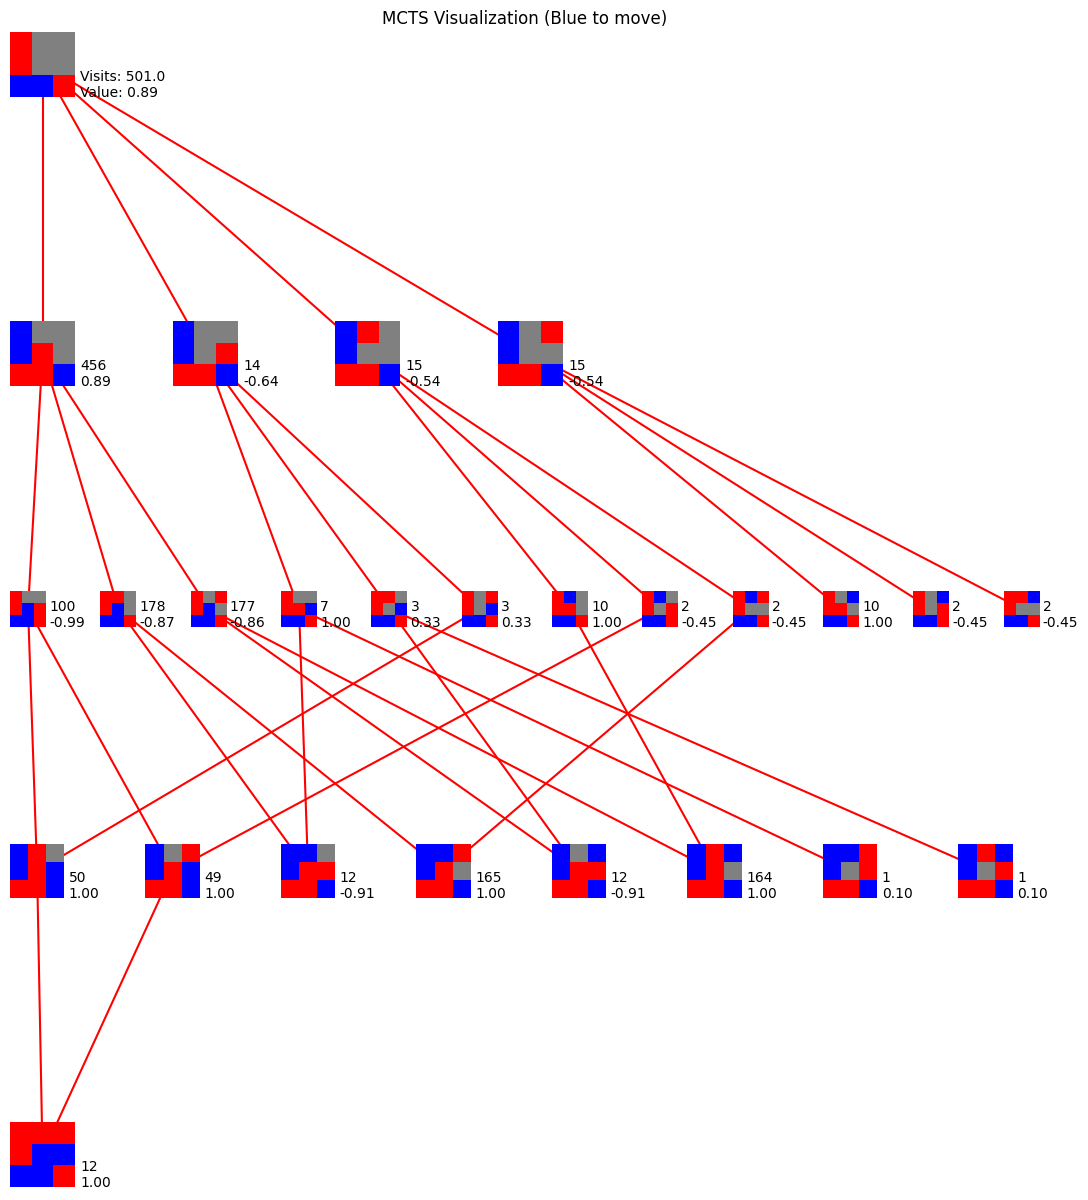

In [33]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.collections import LineCollection

# create discrete colormap
cmap = colors.ListedColormap(['red', 'grey', 'blue'])
bounds = [-2, -0.5, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

def box_pos(num_box, layer_level, spacing, offset=0.0):
    offset = spacing*offset
    draw_pos = [(i*1.5*spacing+offset, -layer_level+offset) for i in range(num_box)]
    return draw_pos

def draw_edges(ax, dp1, dp2, edges):
    # print(edges)
    segments = []
    for p, c in edges:
        segments.append(((dp1[p], dp2[c])))
    # print("segments", segments)
    line_segments = LineCollection(segments, linestyles='solid', color='red', zorder=0)
    ax.add_collection(line_segments)

def draw_layer(ax, to_print, draw_pos, spacing):
    #draw layer
    gx = np.linspace(0, 0.6, 4)
    for pos, t in zip(draw_pos, to_print):
        x, y = pos
        state, text = t
        state = state.reshape((3,3))
        ax.pcolormesh(gx*spacing+x, gx*spacing+y, state, shading='flat', cmap=cmap)
        ax.text(x+0.65*spacing, y, text)


def plot_mcts(ax, mcts, root_index): 
    layer = [root_index]
    value, count = mcts.action_mean_value[root_index].max(), mcts.visit_count[root_index]
    to_print = [(mcts.state[root_index], f"Visits: {count}\nValue: {value:.2f}")]

    to_print_l = [to_print]
    edges_l = []

    layer_row = 0
    while len(layer) > 0:
        next_layer = []
        to_print = []
        edges = []
        seen_states = {}
        for parent_i, state_index in enumerate(layer):
            state = mcts.state[state_index]
            visited_actions, = np.nonzero(mcts.action_visits[state_index])
            visit_counts = mcts.action_visits[state_index][visited_actions]
            action_values = mcts.action_mean_value[state_index, visited_actions]
            for action, count, value in zip(visited_actions, visit_counts, action_values):
                child_state = flip_board(get_next_state(state, action))
                if(child_state.tobytes() in seen_states): #Child already in next layer
                    child_i = seen_states[child_state.tobytes()]
                    edges.append((parent_i, child_i))
                    continue

                if(child_state.tobytes() in mcts.state_lookup): #Child in MCTS
                    child_index = mcts.state_lookup[child_state.tobytes()]
                    next_layer.append(child_index)

                child_i = len(to_print)
                edges.append((parent_i, child_i))
                seen_states[child_state.tobytes()] = child_i
                to_print.append((child_state, f"{count}\n{value:.2f}"))
        
        to_print_l.append(to_print)
        edges_l.append(edges)
        layer_row += 1
        layer = next_layer
    
    spacing_l = np.array([min(0.3, 2/len(to_print)) for to_print in to_print_l])
    layer_level_l = np.cumsum(spacing_l+0.5)

    draw_pos = box_pos(len(to_print_l[0]), layer_level_l[0], spacing_l[0], offset=0.3)
    for i in range(1, len(to_print_l)):
        next_draw_pos = box_pos(len(to_print_l[i]), layer_level_l[i], spacing_l[i], offset=0.3)
        # print(len(draw_pos), len(next_draw_pos))
        draw_edges(ax, draw_pos, next_draw_pos, edges_l[i-1])
        draw_pos = next_draw_pos
    
    for i in range(len(to_print_l)):
        draw_pos = box_pos(len(to_print_l[i]), layer_level_l[i], spacing_l[i])
        draw_layer(ax, to_print_l[i], draw_pos, spacing_l[i])
    # draw_pos = box_pos(len(to_print), layer_level, spacing)

fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.set_aspect('equal')
plot_mcts(ax, mcts, 0)
ax.set_title("MCTS Visualization (Blue to move)")
fig.show()

In [ ]:
print(mcts.action_mean_value[0])

In [ ]:
def self_play_episode(model, num_sims=50, temp_threshold=6):
    train_examples = []
    board = init_board()
    step = 0
    while True:
        mcts = MCTS()
        root_index = mcts.mcts_eval(board, model, num_sims=num_sims)
        
        temp = int(step < temp_threshold)
        pi = mcts.get_action_prob(root_index, temperature=temp)

        train_examples.append((board, pi, step))

        action = np.random.choice(ACTION_DIM, p=pi)
        # print("action", action)
        
        board = flip_board(get_next_state(board, action))

        #Reward is always negative because board is flipped after move. 
        r, game_over = get_reward(board) 
        if(game_over):
            return [(b, p, (-1)**(step-s)) for b, p, s in train_examples]
        step += 1

def batch_examples(train_examples):
    state_batch = jnp.stack([t[0] for t in train_examples])
    pa_batch = jnp.stack([t[1] for t in train_examples])
    r_batch = jnp.stack([t[2] for t in train_examples]).reshape((-1, 1))
    return state_batch, pa_batch, r_batch

train_examples = self_play_episode(toy_model, num_sims=1000)
state_b, pa_b, r_b = batch_examples(train_examples)

In [ ]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  model = TTTModel()
  params = model.init(rng, jnp.ones([1, 9]))['params']

  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, state_b, pa_b, r_b):
  """Train for a single step."""
  def loss_fn(params):
    logits, exp_value = TTTModel().apply({'params': params}, state_b)
    loss = optax.softmax_cross_entropy(logits, pa_b).mean() + jnp.square(r_b - exp_value).mean()
    return loss, (logits, exp_value)
  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, aux = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  # metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state#, metrics

In [ ]:
state = create_train_state(rng, 0.01, 0.1)
for i in range(150):
    print(f"Batch {i}")
    train_examples = []
    for i in range(10):
        train_examples += self_play_episode(lambda x: model_agent(x, {'params': state.params}), num_sims=150)
    state_b, pa_b, r_b = batch_examples(train_examples)
    state = train_step(state, state_b, pa_b, r_b)

In [ ]:
board = np.array([1, -1, 0, -1, 1, 0, -1, 0, -1])
# board = np.zeros_like(board)
print(board.reshape((3,3)))
model = TTTModel()
action_prior, value = model.apply({'params': state.params}, board)
print(action_prior.reshape((3,3)), value)

def learned_agent(board):
    prior = model_agent(board, {'params': state.params})[0]
    prior *= get_valid_mask(board)
    return np.argmax(prior)

def random_agent(board):
    valid_mask = np.float32(get_valid_mask(board))
    valid_mask /= valid_mask.sum()
    return np.random.choice(board.shape[0], p=valid_mask)

def mcts_agent(board):
    mcts = MCTS()
    root_index = mcts.mcts_eval(board, lambda x: model_agent(x, {'params': state.params}), num_sims=100)
    pi = mcts.get_action_prob(root_index, temperature=0)
    if(np.min(pi) < 0):
        print(board.reshape((3,3)))
        print(pi)
        assert False
    action = np.random.choice(ACTION_DIM, p=pi)
    return action

In [ ]:
def mcts_rand_agent(board):
    mcts = MCTS()
    root_index = mcts.mcts_eval(board, toy_model, num_sims=100)
    pi = mcts.get_action_prob(root_index, temperature=0)
    if(np.min(pi) < 0):
        print(board.reshape((3,3)))
        print(pi)
        assert False
    action = np.random.choice(ACTION_DIM, p=pi)
    return action

In [ ]:
def play_match(agent1, agent2):
    board = init_board()
    agents = [agent1, agent2]
    step = 0
    while True:
        a = agents[step%2](board)
        board = flip_board(get_next_state(board, a))
        reward, game_over = get_reward(board)
        # print(step, board)
        if(game_over):
            return reward**step
        step += 1

In [ ]:
fig, axis = plt.subplots()
match_results = []
for i in range(100):
    match_results.append(play_match(mcts_rand_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Random MCTS vs Random")
fig.show()

fig, axis = plt.subplots()
match_results = []
for i in range(100):
    match_results.append(play_match(mcts_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("MCTS vs Random")
fig.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6.5,8))

match_results = []
for i in range(1000):
    match_results.append(play_match(learned_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[0, 0].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[0, 0].set_title("Learned vs Random")

match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[0, 1].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[0, 1].set_title("Random vs Random")

match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, learned_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[1, 0].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[1, 0].set_title("Random vs Learned")

# match_results = []
# for i in range(1000):
#     match_results.append(play_match(learned_agent, learned_agent))
# counts, bins = np.histogram(match_results, bins=3)
# axes[1, 1].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
# axes[1, 1].set_title("Learned vs Learned")

fig.show()

In [ ]:
match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, random_agent))
plt.hist(match_results)